# The Data Handler
This notebook will handle the data that will be used in the project thesis. 

The functions of the notebook can be defined as follows: 
1. Extract the data from the Cognite API
2. Statistical analysis of the data
3. Data standardisation/scaling
4. Data cleaning and handling missing values
5. Splitting into training, validation and testing sets
6. Saving the data files as numpy arrays such that they easily can be imported in other notebooks. 

In [1]:
%reset -f

First import some relevant libraries.

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
from datetime import datetime

from cognite.v05.assets import get_assets
from cognite.v05.assets import get_asset
from cognite.v05.timeseries import get_datapoints_frame

In [31]:
# define global root path
ROOT_PATH = os.path.abspath(".").split("main")[0]

# configure matplotlib params and plotting
## use seaborn as this gives nicer plots than the standard 
sns.set()
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})

rc('figure', figsize=(15,6))
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)
rc('axes', labelsize=13, titlesize=14)
rc('legend', fontsize=13, handlelength=2)

## (1) Extract the data from Cognite's API
Authenticate session with the Cognite API. 

In [4]:
# authenticate session with Cognite API
from cognite.config import configure_session
from credentials import COGNITE_API_KEY
configure_session(COGNITE_API_KEY, 'publicdata')

Define the tags to extract time series from, as well as a function to load the data

In [5]:
input_tags = ['VAL_23-FT-92512:X.Value', 'VAL_23-TT-92533:X.Value', 'VAL_23-PT-92532:X.Value']
control_tags = ['VAL_23_ZT_92543:Z.X.Value', 'VAL_23_ZT_92538:Z.X.Value', 'VAL_23-KA-9101_ASP:VALUE']
output_tags = ['VAL_23-FT-92537-01:X.Value', 'VAL_23-TT-92539:X.Value', 'VAL_23-PT-92539:X.Value']

feature_tags = input_tags + control_tags
target_tags = output_tags
headers = feature_tags + target_tags

def load_data():
    start = datetime(2018, 1, 1)
    end = datetime(2018, 3, 1)
    time_interval_seconds = 60
    granularity = str(time_interval_seconds) + 's'
    aggregates = ['avg']

    data = get_datapoints_frame(feature_tags + target_tags,
                                start=start,
                                end=end,
                                granularity=granularity,
                                aggregates=aggregates)


    # extract column names for features and targets
    new_target_tags = [label for label in list(data.columns) if
                       any([label.startswith(var_name) for var_name in target_tags])]
    new_feature_tags = [label for label in list(data.columns) if
                        not any([label.startswith(var_name) for var_name in target_tags])]
    if 'timestamp' in new_feature_tags:
        new_feature_tags.remove('timestamp')

    return data, {'target_tags': new_target_tags, 'feature_tags': new_feature_tags}

In [6]:
data, tags = load_data()

if 'timestamp' in data.columns:
    ts = data.timestamp
    T = pd.to_datetime(data.timestamp,unit="ms")
    data = data.drop(['timestamp'], axis=1)

feature_tags = tags['feature_tags']
target_tags = tags['target_tags']
headers = tags['feature_tags'] + tags['target_tags']

print(data.shape)
data.head()

(84392, 9)


,VAL_23-FT-92512:X.Value|average,VAL_23-TT-92533:X.Value|average,VAL_23-PT-92532:X.Value|average,VAL_23_ZT_92543:Z.X.Value|average,VAL_23_ZT_92538:Z.X.Value|average,VAL_23-KA-9101_ASP:VALUE|average,VAL_23-FT-92537-01:X.Value|average,VAL_23-TT-92539:X.Value|average,VAL_23-PT-92539:X.Value|average
0,86513.124803,32.397923,2.678199,41.379160,87.362364,8770.460167,161173.163042,123.309204,12.641209
1,95862.072246,32.209867,2.796514,39.127938,89.474011,9262.324366,164465.788551,123.537807,12.957911
2,96191.585299,32.300005,2.805034,39.916075,89.930273,9270.730516,166973.184688,123.755169,13.021748
3,91128.616402,32.401819,2.755383,40.628347,90.656906,9146.055633,164402.687854,123.898180,12.874957
4,91532.345848,32.384804,2.768137,40.680047,90.655101,9265.670518,164649.223984,123.924612,12.896848


#### Plot the outputs

/home/shomeb/h/halvorre/project-thesis/code/venv/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


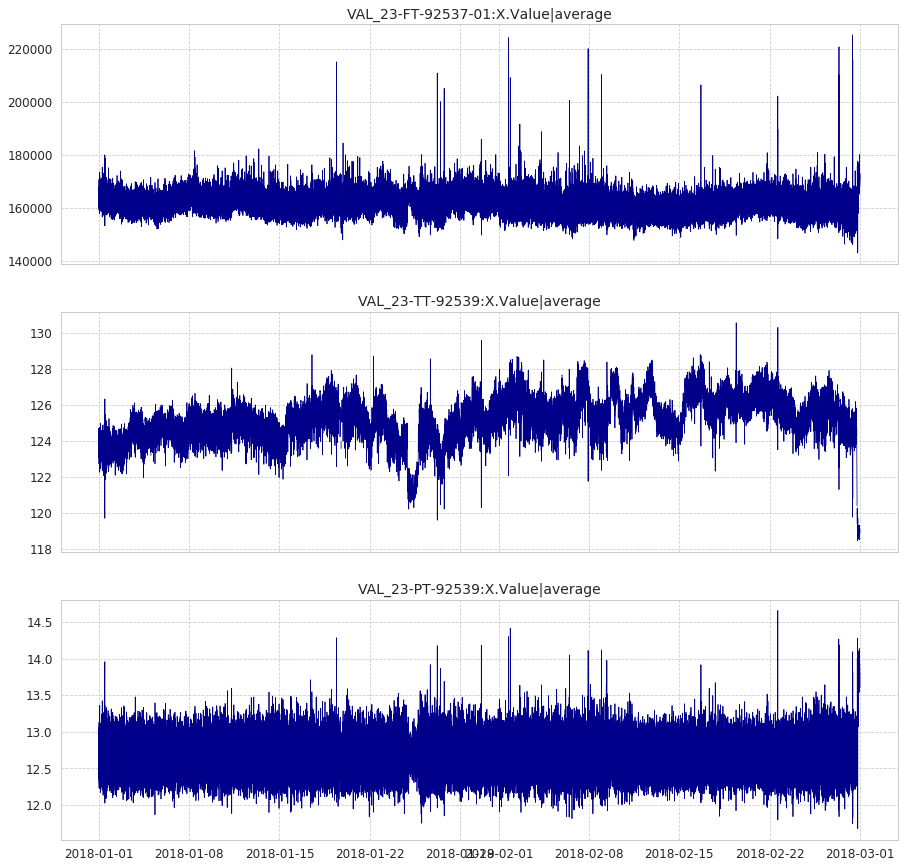

In [7]:
# plot the outputs
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize = (15,15))
for i, tag in enumerate(target_tags):
    ax = axs[i]
    ax.plot_date(T, data[tag], color="darkblue", markersize=0, linewidth=0.75,linestyle="-")
    ax.set_title(tag)

fig.show() 

#### Plot the inputs

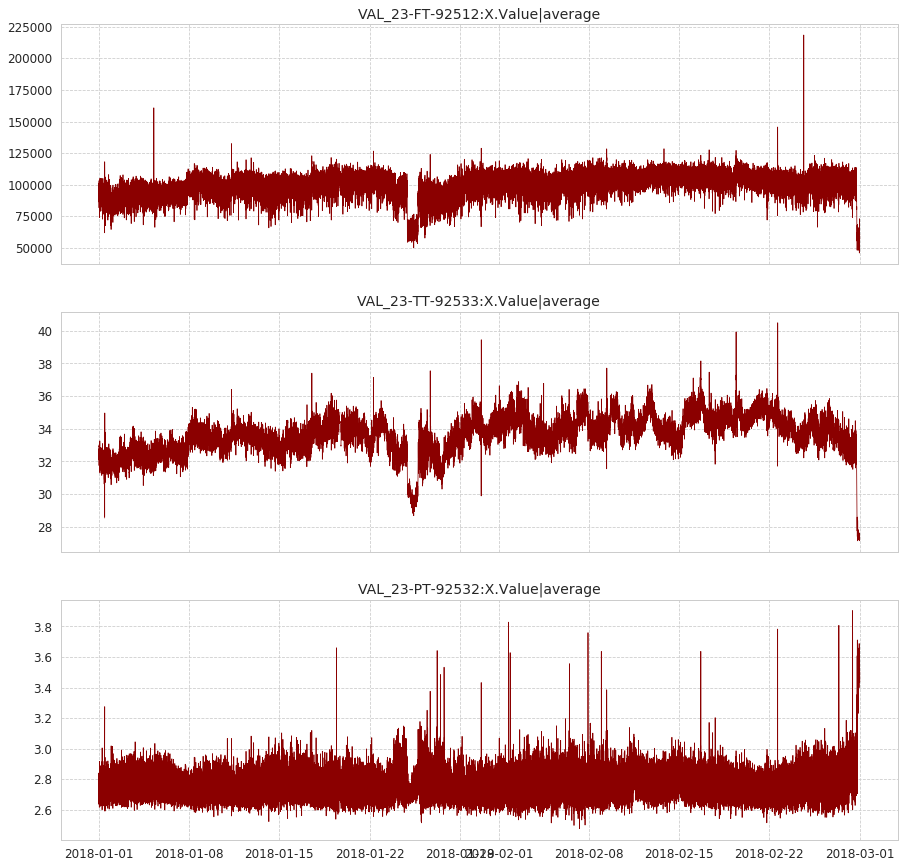

In [8]:
# plot the input tags
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(15,15))
for i, tag in enumerate(feature_tags[:len(input_tags)]):
    ax = axs[i]
    ax.plot_date(T, data[tag], color="darkred", markersize=0, linewidth=0.75,linestyle="-")
    ax.set_title(tag)

#### Plot the control tags

/home/shomeb/h/halvorre/project-thesis/code/venv/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


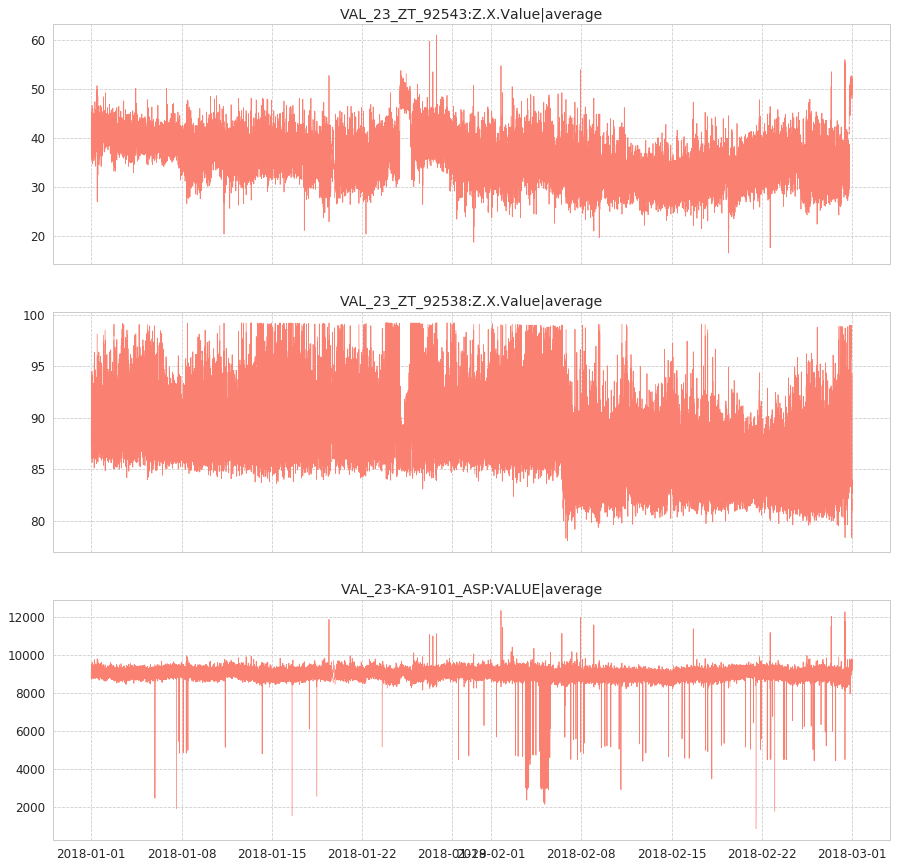

In [9]:
# plot the control tags
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize = (15,15))
for i, tag in enumerate(feature_tags[len(input_tags):]):
    ax = axs[i]
    ax.plot_date(T, data[tag], color="salmon", markersize=0, linewidth=0.75,linestyle="-")
    ax.set_title(tag)

fig.show()

We can also zoom in on 12 hours worth of data, i.e. 720 time steps. Look at one output_tag, one input tag and one control tag. 

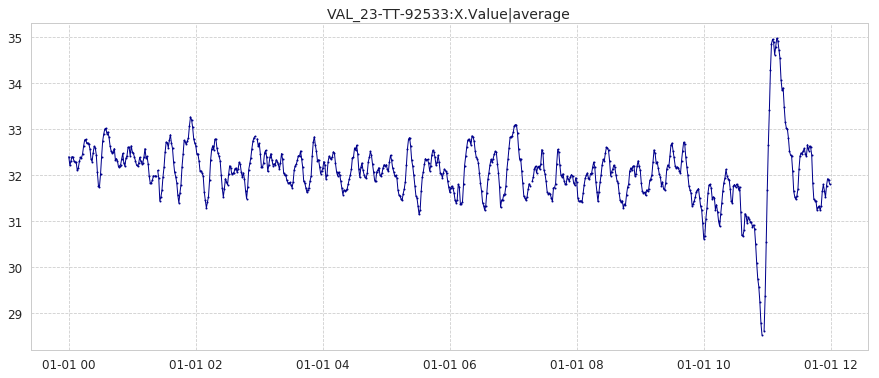

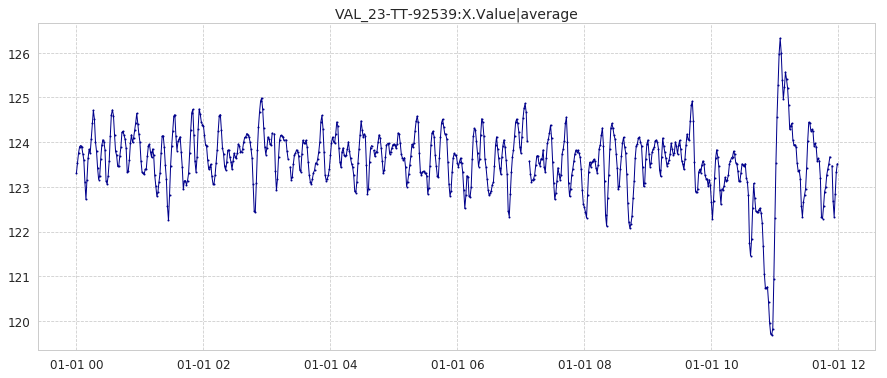

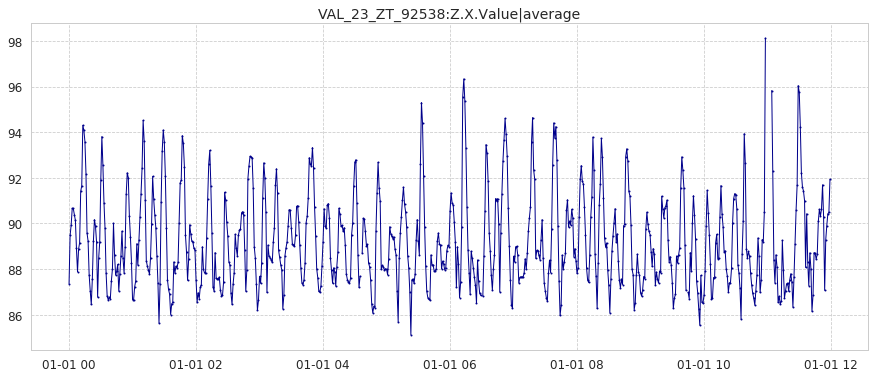

In [10]:
# zoom in on 12 hours
num_obs = 12*60

tags = [feature_tags[1],target_tags[1], feature_tags[len(input_tags)+1]]
for tagname in tags: 
    plt.figure()
    plt.plot_date(T[:num_obs], data[tagname][:num_obs], color="darkblue", markersize=1.0, linewidth=1.0, linestyle="-")
    plt.title(tagname)
plt.show()

## (2-3) Data scaling & Statistical analysis
For applying the data with deep learning, the data must be scaled. Many options here: MinMax-scaling [0-1], standardization (mean 0 and variance 1) are the most common. First, let's get some information about the data at hand.

### Statistical properties of the data

In [11]:
dfmeans = data.mean().tolist()
dfmedians = data.median().tolist()
dfstds = data.std().tolist()
dfmaxs = data.max().tolist()
dfmins = data.min().tolist()
dfdiff_maxmin = np.subtract(dfmaxs,dfmins)

cols = ['mean', 'median', 'std', 'max', 'min', 'diff']
stats_matr = np.array([dfmeans, dfmedians, dfstds, dfmaxs, dfmins, dfdiff_maxmin])
stats_df = pd.DataFrame(stats_matr.T, index=headers, columns=cols)
stats_df

,mean,median,std,max,min,diff
VAL_23-FT-92512:X.Value|average,99721.306903,101045.928602,8551.874014,218388.373800,46041.644296,172346.729504
VAL_23-TT-92533:X.Value|average,33.647804,33.729218,1.155972,40.489575,27.140860,13.348716
VAL_23-PT-92532:X.Value|average,2.769742,2.758910,0.091404,3.903499,2.477754,1.425745
VAL_23_ZT_92543:Z.X.Value|average,35.662958,35.474303,4.138515,60.949738,16.510971,44.438767
VAL_23_ZT_92538:Z.X.Value|average,88.386357,88.003080,3.474147,99.208647,78.045508,21.163139
VAL_23-KA-9101_ASP:VALUE|average,8987.197310,9005.659402,361.295023,12353.753855,882.941567,11470.812288
VAL_23-FT-92537-01:X.Value|average,161401.177306,161256.123940,3554.092206,225402.804437,143015.776954,82387.027484
VAL_23-TT-92539:X.Value|average,125.228499,125.267680,1.196098,130.570725,118.438130,12.132595
VAL_23-PT-92539:X.Value|average,12.701911,12.705057,0.251553,14.656747,11.678940,2.977807


Export this to latex such that it can be imported in the latex report

In [12]:
names = []
for s in stats_df.index.tolist():
    tmp = s.split(':')[0] # remove last part
    tmp = tmp.replace("VAL_23-","") # remove VAL_23-
    tmp = tmp.replace("VAL_23_","") # remove VAL_23_
    names.append(tmp)

stats_df_round = stats_df.round(3)
stats_df_round.index = names
stats_df_round = stats_df_round.drop(['diff'],axis=1)
tex = stats_df_round.to_latex(column_format="l" + "c"*len(stats_df_round.columns), bold_rows=True)
print(tex)

\begin{tabular}{lccccc}
\toprule
{} &        mean &      median &       std &         max &         min \\
\midrule
\textbf{FT-92512   } &   99721.307 &  101045.929 &  8551.874 &  218388.374 &   46041.644 \\
\textbf{TT-92533   } &      33.648 &      33.729 &     1.156 &      40.490 &      27.141 \\
\textbf{PT-92532   } &       2.770 &       2.759 &     0.091 &       3.903 &       2.478 \\
\textbf{ZT\_92543   } &      35.663 &      35.474 &     4.139 &      60.950 &      16.511 \\
\textbf{ZT\_92538   } &      88.386 &      88.003 &     3.474 &      99.209 &      78.046 \\
\textbf{KA-9101\_ASP} &    8987.197 &    9005.659 &   361.295 &   12353.754 &     882.942 \\
\textbf{FT-92537-01} &  161401.177 &  161256.124 &  3554.092 &  225402.804 &  143015.777 \\
\textbf{TT-92539   } &     125.228 &     125.268 &     1.196 &     130.571 &     118.438 \\
\textbf{PT-92539   } &      12.702 &      12.705 &     0.252 &      14.657 &      11.679 \\
\bottomrule
\end{tabular}



#### Density plots using KDE
Density plots using Kernel Density Estimation of each feature: 

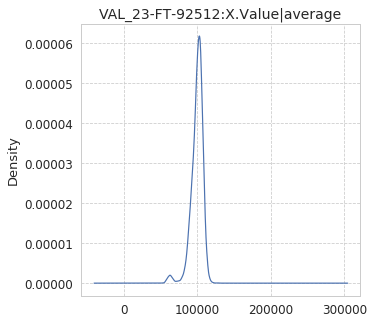

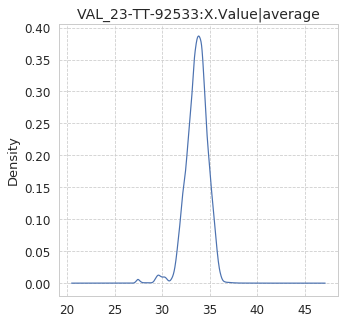

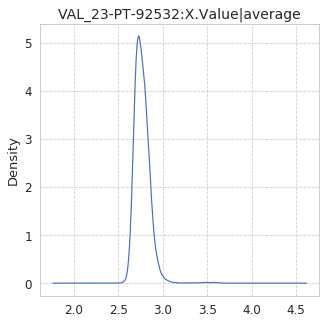

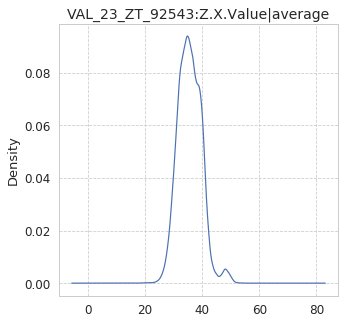

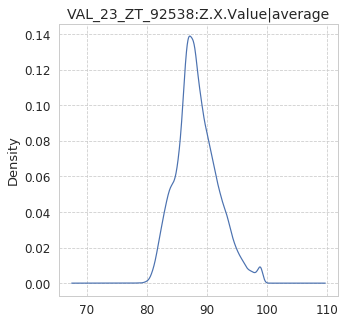

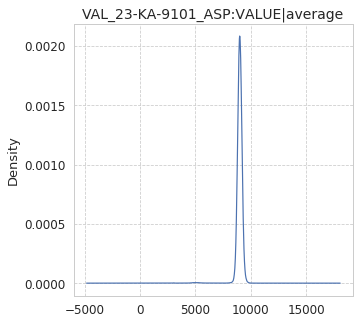

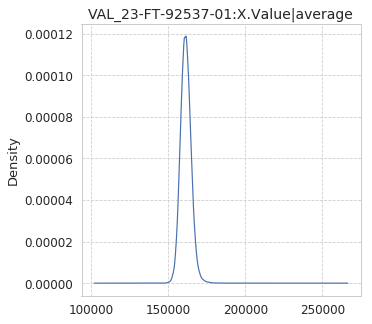

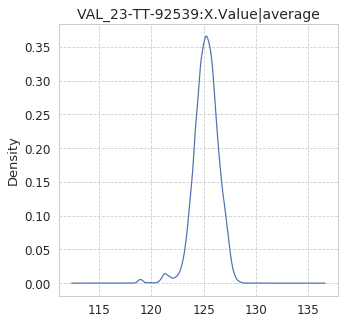

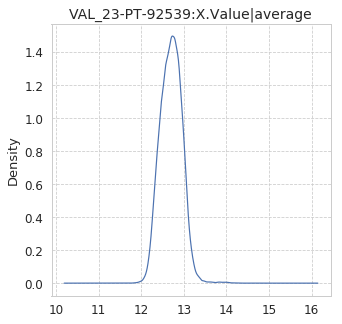

In [13]:
for i in range(len(headers)):
    plt.figure(figsize=(5,5))
    density_plot = data[headers[i]].plot.kde()
    plt.title(headers[i])
    plt.show()

Based on these statistics, the following scalings are made: 
* The sensor values look like they follow a scaled normal distribution. 
* The ZT-senors are percentage values, and will be scaled seperately.

The ZT sensors will be scaled by simply dividing by 100, effectively scaling them in the range [0,1]. 
The latter sensor values will be standardized with zero mean and unit variance.  

In [14]:
train_size = int(0.6 * len(data))
valid_size = int(0.2 * len(data))
test_size = len(data) - (train_size + valid_size)

# seperate between features to divide and features to standardize
features_to_divide = ['VAL_23_ZT_92543:Z.X.Value|average', 'VAL_23_ZT_92538:Z.X.Value|average']
features_to_standardize = [name for name in headers if name not in features_to_divide]

means = data[:train_size].mean().tolist()
stds = data[:train_size].std().tolist()

# will set means of the features_to_divide to 0 and standard deviation 100
for feature in features_to_divide: 
    idx = headers.index(feature)
    means[idx] = 0
    stds[idx] = 100

df_scaled = data.copy()
df_scaled -= means
df_scaled /= stds

# verify that the features are scaled to [0,1]
print("Features to divide:")
print("max :", df_scaled[features_to_divide].max().tolist())
print("min :", df_scaled[features_to_divide].min().tolist())
print("mean :", df_scaled[features_to_divide].mean().tolist())

# verify that mean is approx 0 and std approx 1 of standardized data
print("\nFeatures to standardize:")
print("=== Training data ===")
print("Standardized means:\n", df_scaled[features_to_standardize][:train_size].mean().tolist())
print("Standardized stds:\n", df_scaled[features_to_standardize][:train_size].std().tolist())

print("\n=== Whole data ===")
print("Standardized means:\n", df_scaled[features_to_standardize].mean().tolist())
print("Standardized stds:\n", df_scaled[features_to_standardize].std().tolist())

Features to divide:
max : [0.6094973834808537, 0.9920864703875937]
min : [0.16510971232205343, 0.7804550786754999]
mean : [0.35662957929520467, 0.8838635684643509]

Features to standardize:
=== Training data ===
Standardized means:
 [3.1262088891166e-14, -2.5459585063353096e-14, -4.365451862651321e-13, -7.642026967141709e-14, 3.048591206917469e-13, 1.293641391801691e-12, 6.031165612878287e-13]
Standardized stds:
 [1.0000000000000024, 0.9999999999999988, 0.9999999999999958, 0.9999999999999996, 1.0000000000000013, 0.9999999999999933, 0.9999999999999981]

=== Whole data ===
Standardized means:
 [0.31278983652901077, 0.3872511418263963, 0.15162645390880963, -0.04189295697312151, -0.18140719895550259, 0.38316905209723184, 0.017878833654794073]
Standardized stds:
 [0.9952425388591829, 1.0960326337472726, 1.1822372163453954, 0.8781528735412972, 1.0526196085300552, 1.1193825191961548, 1.0193329957918547]


Again, let's review the statistics: 

In [15]:
dfmeans = df_scaled.mean().tolist()
dfmedians = df_scaled.median().tolist()
dfstds = df_scaled.std().tolist()
dfmaxs = df_scaled.max().tolist()
dfmins = df_scaled.min().tolist()
dfdiff_maxmin = np.subtract(dfmaxs,dfmins)

cols = ['mean', 'median', 'std', 'max', 'min', 'diff']
stats_matr = np.array([dfmeans, dfmedians, dfstds, dfmaxs, dfmins, dfdiff_maxmin])
stats_df = pd.DataFrame(stats_matr.T, index=headers, columns=cols)
stats_df

,mean,median,std,max,min,diff
VAL_23-FT-92512:X.Value|average,0.312790,0.466946,0.995243,14.122922,-5.934295,20.057217
VAL_23-TT-92533:X.Value|average,0.387251,0.464444,1.096033,6.874263,-5.782296,12.656558
VAL_23-PT-92532:X.Value|average,0.151626,0.011519,1.182237,14.815900,-3.625011,18.440912
VAL_23_ZT_92543:Z.X.Value|average,0.356630,0.354743,0.041385,0.609497,0.165110,0.444388
VAL_23_ZT_92538:Z.X.Value|average,0.883864,0.880031,0.034741,0.992086,0.780455,0.211631
VAL_23-KA-9101_ASP:VALUE|average,-0.041893,0.002980,0.878153,8.140759,-19.739854,27.880613
VAL_23-FT-92537-01:X.Value|average,-0.181407,-0.224368,1.052620,18.774029,-5.626633,24.400661
VAL_23-TT-92539:X.Value|average,0.383169,0.419838,1.119383,5.382754,-5.971677,11.354431
VAL_23-PT-92539:X.Value|average,0.017879,0.030626,1.019333,7.939171,-4.127356,12.066527


The reason why the means and stds are not 0 and 1 respectively is because the means and stds were calculated by the TRIANING data. Using the whole dataset in normalization is using information you don't have. This will give overly confindent performance estimates!

#### Visualise the discharge flow before and after scaling

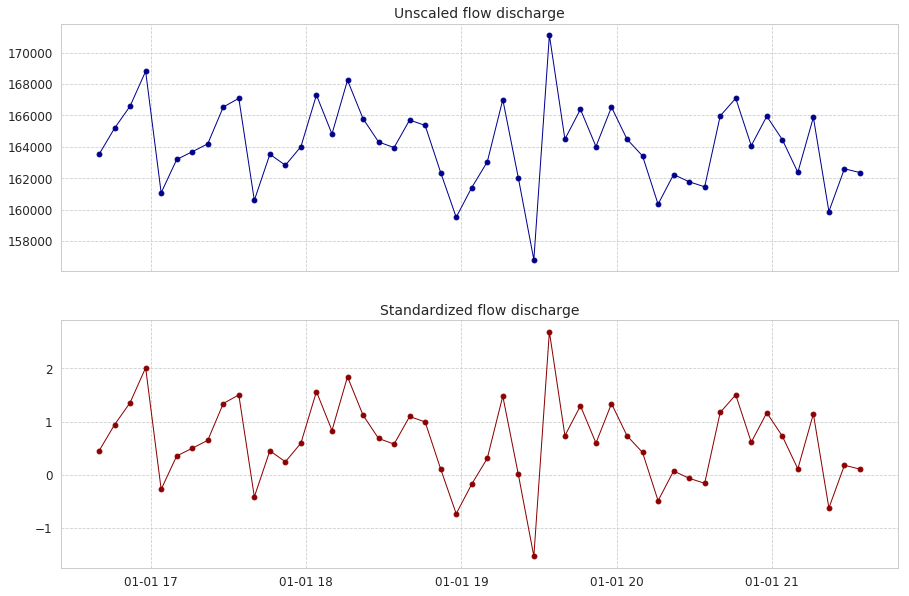

In [16]:
# visualise the discharge flow before and after scaling
tagname = 'VAL_23-FT-92537-01:X.Value|average'
inds = np.arange(1000,1300,headers.index(tagname))

fig, (ax1,ax2) = plt.subplots(2,1,sharex=True, figsize=(15,10))
ax1.plot_date(T[inds], data[tagname][inds], linewidth=1.0, linestyle="-", color="darkblue")
ax1.set_title("Unscaled flow discharge")
ax2.plot_date(T[inds], df_scaled[tagname][inds], linewidth=1.0, linestyle="-", color="darkred")
ax2.set_title("Standardized flow discharge")
plt.show()

## (4) Handling missing data points and NA values

Now, we must handle NA values. They have until now been ignored and have not affected the scaling of the data in any way. They will be removed by forward- and backwards filling. 

First, how many NA values are there for each feature? 

In [17]:
num_na = [int(i) for i in df_scaled.isna().sum().tolist()]
na_percentage = np.divide(num_na,len(df_scaled))*100

na_df = pd.DataFrame(np.array([num_na,na_percentage]).T, index=headers, columns=["# NA", "%"])
na_df_tex = na_df.copy()
na_df_tex.index = names
na_tex = na_df_tex.to_latex(column_format="l" + "c"*len(na_df_tex.columns), bold_rows=True)
print(na_tex)

na_df

\begin{tabular}{lcc}
\toprule
{} &    \# NA &         \% \\
\midrule
\textbf{FT-92512   } &    49.0 &  0.058062 \\
\textbf{TT-92533   } &   636.0 &  0.753626 \\
\textbf{PT-92532   } &    27.0 &  0.031994 \\
\textbf{ZT\_92543   } &   930.0 &  1.102000 \\
\textbf{ZT\_92538   } &  3909.0 &  4.631956 \\
\textbf{KA-9101\_ASP} &   606.0 &  0.718078 \\
\textbf{FT-92537-01} &    46.0 &  0.054508 \\
\textbf{TT-92539   } &  1243.0 &  1.472888 \\
\textbf{PT-92539   } &    49.0 &  0.058062 \\
\bottomrule
\end{tabular}



,# NA,%
VAL_23-FT-92512:X.Value|average,49.0,0.058062
VAL_23-TT-92533:X.Value|average,636.0,0.753626
VAL_23-PT-92532:X.Value|average,27.0,0.031994
VAL_23_ZT_92543:Z.X.Value|average,930.0,1.102000
VAL_23_ZT_92538:Z.X.Value|average,3909.0,4.631956
VAL_23-KA-9101_ASP:VALUE|average,606.0,0.718078
VAL_23-FT-92537-01:X.Value|average,46.0,0.054508
VAL_23-TT-92539:X.Value|average,1243.0,1.472888
VAL_23-PT-92539:X.Value|average,49.0,0.058062


We see that especially the ZT tags are prone to NA values. This either suggests that we should completely remove them or not, but will have to research how they affect the results. They are kept for now. NA values are fixed by forward- and backwards filling the values. 

In [18]:
df_scaled = df_scaled.fillna(method='ffill')
df_scaled = df_scaled.fillna(method='backfill')

num_na = [int(i) for i in df_scaled.isna().sum().tolist()]
na_percentage = np.divide(num_na,len(df_scaled))*100

na_df = pd.DataFrame(np.array([num_na,na_percentage]).T, index=headers, columns=["# NA", "%"])
na_df

,# NA,%
VAL_23-FT-92512:X.Value|average,0.0,0.0
VAL_23-TT-92533:X.Value|average,0.0,0.0
VAL_23-PT-92532:X.Value|average,0.0,0.0
VAL_23_ZT_92543:Z.X.Value|average,0.0,0.0
VAL_23_ZT_92538:Z.X.Value|average,0.0,0.0
VAL_23-KA-9101_ASP:VALUE|average,0.0,0.0
VAL_23-FT-92537-01:X.Value|average,0.0,0.0
VAL_23-TT-92539:X.Value|average,0.0,0.0
VAL_23-PT-92539:X.Value|average,0.0,0.0


## (5) Split to training, validation and testing sets
The data is now split into training, validation and testing sets with 60-20-20. 
Furthermore, they are converted to numpy arrays. 

In [19]:
df2np = df_scaled.values
df2np_train = df2np[:train_size]
df2np_valid = df2np[train_size:-test_size]
df2np_test = df2np[-test_size:]

print("=========== SUMMARY ===========")
print("Total number of observations : {}".format(len(df2np)))
print("Size of train+valid+test     : {}".format(len(df2np_train) + len(df2np_valid) + len(df2np_test)))
print("Size of training set         : {}".format(len(df2np_train)))
print("Size of validation set       : {}".format(len(df2np_valid)))
print("Size of testing set          : {}".format(len(df2np_test)))

=========== SUMMARY ===========
Total number of observations : 84392
Size of train+valid+test     : 84392
Size of training set         : 50635
Size of validation set       : 16878
Size of testing set          : 16879


#### Plots of the training, validation and testing sets
Plot the discharge flow for the testing, training and validation sets. 

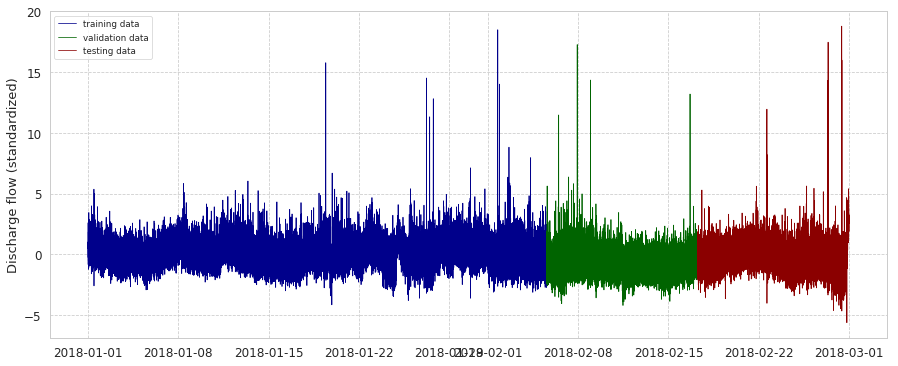

In [20]:
tagname = 'VAL_23-FT-92537-01:X.Value|average' # discharge flow
delta = 1

plt.figure()
plt.plot_date(x=T[:train_size:delta], y=df_scaled[tagname][:train_size:delta], markersize=0,
              linewidth = 0.75, color="darkblue", linestyle="-", label="training data")
plt.plot_date(x=T[train_size:-test_size:delta], y=df_scaled[tagname][train_size:-test_size:delta],  markersize=0,
              linewidth = 0.75, color="darkgreen", linestyle="-", label="validation data")
plt.plot_date(x=T[-test_size::delta], y=df_scaled[tagname][-test_size::delta],  markersize=0,
              linewidth = 0.75, color="darkred", linestyle="-", label="testing data")
plt.ylabel("Discharge flow (standardized)")
plt.legend(frameon=True)
plt.show()

## (6) Save the data
The datasets are now saved to respective files such that they easily can be worked with in other files

In [21]:
# save the complete datasets as pickled dataframes
data.to_pickle(ROOT_PATH + "data/unprocessed_data.pkl")
df_scaled.to_pickle(ROOT_PATH + "data/standardized/df_scaled.pkl")

# save the standardized data sets
np.save(ROOT_PATH + "data/standardized/standardized_complete.npy", df2np)
np.save(ROOT_PATH + "data/standardized/standardized_train.npy", df2np_train)
np.save(ROOT_PATH + "data/standardized/standardized_valid.npy", df2np_valid)
np.save(ROOT_PATH + "data/standardized/standardized_test.npy", df2np_test)

# save metadata; headers, means, standard deviations
np.save(ROOT_PATH + "data/metadata/feature_tags.npy", feature_tags)
np.save(ROOT_PATH + "data/metadata/target_tags.npy", target_tags)
np.save(ROOT_PATH + "data/metadata/means.npy", means)
np.save(ROOT_PATH + "data/metadata/stds.npy", stds)

# save the time variable for plotting
np.save(ROOT_PATH + "data/metadata/timevec_train.npy", T[:train_size])
np.save(ROOT_PATH + "data/metadata/timevec_valid.npy", T[train_size:-test_size])
np.save(ROOT_PATH + "data/metadata/timevec_test.npy", T[-test_size:])

In [30]:
# make a dummy dataset of a few first observations
num_obs = [6000,20000,50000]
for n in num_obs: 
    dum_trainsize = int(0.6 * n)
    dum_validsize = int(0.2 * n)
    dum_testsize = n - (dum_trainsize + dum_validsize)

    dummy_train = df2np_train[:dum_trainsize]
    dummy_valid = df2np_valid[:dum_validsize]
    dummy_test = df2np_test[:dum_testsize]
    
    dummy_data = np.concatenate((dummy_train,dummy_valid,dummy_test),axis=0)

    print("Saving dummy files with num obs =",n)
    print(dummy_train.shape, dummy_valid.shape, dummy_test.shape)

    np.save(ROOT_PATH + "data/dummy_data/dummy_complete_{0}.npy".format(n), dummy_data)
    np.save(ROOT_PATH + "data/dummy_data/dummy_train_{0}.npy".format(n), dummy_train)
    np.save(ROOT_PATH + "data/dummy_data/dummy_valid_{0}.npy".format(n), dummy_valid)
    np.save(ROOT_PATH + "data/dummy_data/dummy_test_{0}.npy".format(n), dummy_test)
    print()

Saving dummy files with num obs = 6000
(3600, 9) (1200, 9) (1200, 9)

Saving dummy files with num obs = 20000
(12000, 9) (4000, 9) (4000, 9)

Saving dummy files with num obs = 50000
(30000, 9) (10000, 9) (10000, 9)

